## Install ffmpeg in anaconda to run the animation.

In [1]:
import numpy as np
from scipy import integrate
from matplotlib import cm
from matplotlib import animation
import matplotlib.pyplot as plt

In [2]:
dx = 0.05
dy = 0.05
dt = 0.001
Tf = 2
Nt = int(np.ceil(Tf/dt))+4

a = 0
b = 1
c = 0 
d = 1

Nx = int(round((b-a)/dx)+1)
Ny = int(round((d-c)/dx)+1)

hx = 1/(Nx-1)
hy = 1/(Ny-1)
h  = hx


x = np.linspace(a+hx,b-hx,Nx-2)
y = np.linspace(c+hy,d-hy,Ny-2)
t = np.linspace(0,Tf,Nt)

X, Y= np.meshgrid(x,y)


In [3]:
#Create finite element approximation of function.
def Initial_pos(N,b,a,f):
    h = (b-a)/(N+1)
    def f_1(x,f,begin):
        return 1/h**2*f(x)*(x-begin)
    def f_2(x,f,end):
        return 1/h**2*f(x)*(end-x)
    pos = np.linspace(a,b,N+2)
    Init = np.zeros(N+2)
    for i in range(1,N+1):
        dx1 = np.linspace(pos[i-1],pos[i],1001)
        dx2 = np.linspace(pos[i],pos[i+1],1001)
        Init[i] = integrate.simpson(f_1(dx1,f,pos[i-1]),dx1)+integrate.simpson(f_2(dx2,f,pos[i+1]),dx2)
    return Init

In [4]:
#Stiffness matrix
def A_2D(A,B,nx,ny):
    C = []
    C.append([A,B]+[Zero for i in range(ny-2)])
    j = k =0
    for j in range(nx-2):
        k = ny-1-j
        z_J = [Zero for i in range(j)]+[B,A,B]+[Zero for i in range(k-2)]
        C.append(z_J)
    C.append([Zero for i in range(ny-2)]+[B,A])
    C = np.block(C)
    return -1/h*C

In [5]:
A = np.diagflat([-4 for i in range(Nx-2)],0)+\
np.diagflat([1 for i in range(Nx-3)],1) +\
np.diagflat([1 for i in range(Nx-3)],-1)
B = np.diagflat([1 for i in range(Nx-2)],0)
Zero = np.zeros([Nx-2,Ny-2])

In [6]:
A_ = A_2D(A,B,Nx-2,Ny-2)

In [7]:
#Mass matrix
def M_2D(E,F,nx,ny):
    C = []
    C.append([E,F]+[Zero for i in range(ny-2)])
    j = k =0
    for j in range(nx-2):
        k = ny-1-j
        z_J = [Zero for i in range(j)]+[F,E,F]+[Zero for i in range(k-2)]
        C.append(z_J)
    C.append([Zero for i in range(ny-2)]+[F,E])
    C = np.block(C)
    return h*C

In [8]:
E = np.diagflat([1/2 for i in range(Nx-2)],0)+\
np.diagflat([1/8 for i in range(Nx-3)],1) +\
np.diagflat([1/8 for i in range(Nx-3)],-1)
F = np.diagflat([1/8 for i in range(Nx-2)],0)
Zero = np.zeros([Nx-2,Ny-2])

In [9]:
M_ = M_2D(E,F,Nx-2,Ny-2)

In [10]:
u = np.zeros([Nt,Nx-2,Ny-2])

#IC
def f(x,y):
    return np.sin(2*np.pi*x)*np.sin(2*np.pi*y)


def g(x,y):
    return 1*np.cos(4*np.pi*x)*np.cos(10*np.pi*y)


x_mid = 1/2
y_mid = 1/2
def h(x,y):
    return np.maximum(0,10-(abs(x_mid - x) + abs(y_mid - y)))/10
#BC

u[:,:,0] = 0
u[:,:,-1] = 0
u[:,0,:] = 0
u[:,-1,:] = 0

#IC
u[0,:,:] = h(X,Y)
u[1,:,:] = h(X,Y)#+dt*g(X,Y)
u[2,:,:] = h(X,Y)#+dt*g(X,Y)
u[3,:,:] = h(X,Y)#+dt*g(X,Y)

#Set p and epsilon value
epsilon = 0.01*dt
p=4

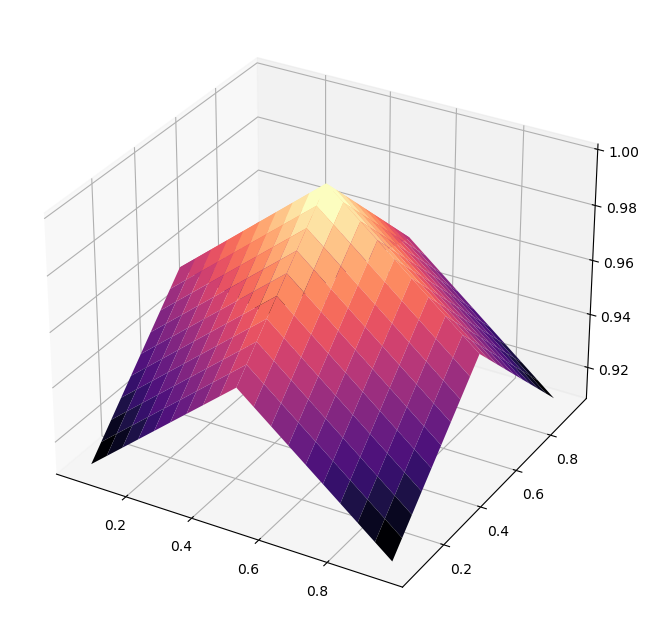

In [11]:
fig2 = plt.figure(figsize=(10,8))
ax2= fig2.add_subplot(111,projection='3d')
ax2.plot_surface(X,Y, u[1,:,:], cmap="magma")

In [12]:
for j in range(4,Nt):
    RIGHT = (4*(epsilon/dt)-2)*(epsilon/dt-1)*M_@np.ndarray.flatten(u[j-1,:,:]) - \
    (6*(epsilon/dt)**2-6*(epsilon/dt)+1)*M_@np.ndarray.flatten(u[j-2,:,:]) +\
    2*(epsilon/dt)*(2*(epsilon/dt)-1)*M_@np.ndarray.flatten(u[j-3,:,:]) -\
    (epsilon/dt)**2*M_@np.ndarray.flatten(u[j-4,:,:])+\
    -dt**2*p/2*np.ndarray.flatten(u[j-1,:,:])**(p-1)#-dt**2*A_@np.ndarray.flatten(u[j-1,:,:])
    LEFT = ((epsilon/dt)-1)**2*M_+dt**2*A_
    x = np.linalg.solve(LEFT,RIGHT)
    u[j,:,:] = x.reshape(len(u[0,:,:]),len(u[0,:,:]))

In [13]:
from IPython.display import Audio
from IPython.core.display import display
Aud = np.zeros(Nt)
Aud = u[:,Nx//2,Ny//2] 
#Aud = (10000*Aud).round()

def beep():
    display(Audio(Aud,rate=100,normalize=True))
beep()

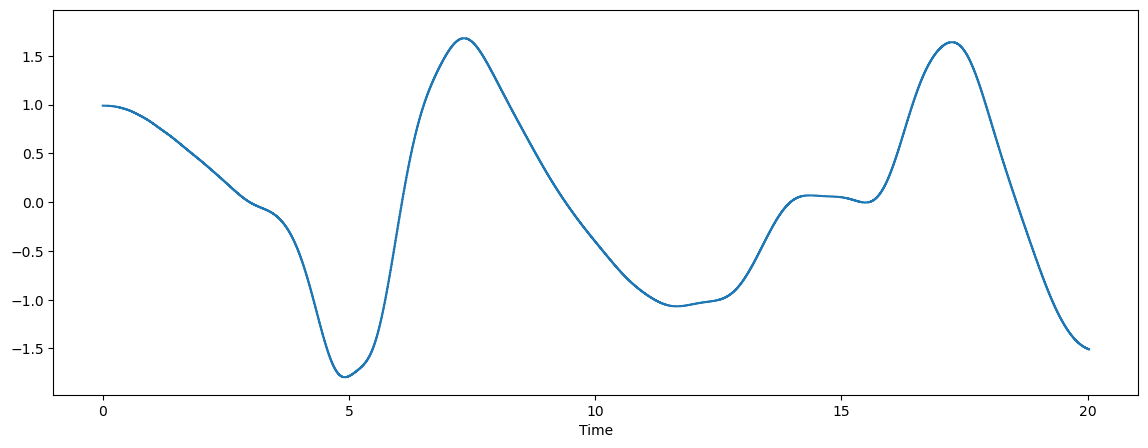

In [14]:
import librosa.display
import soundfile as sf
plt.figure(figsize=(14, 5))
librosa.display.waveshow(Aud,sr=100)
sf.write('stereo_file1.wav', Aud, 100, 'PCM_24')

In [17]:
Nt

2004

In [18]:
Nt/Tf

1002.0

In [25]:
#Playing with wave audio in python, can ignore
from IPython.display import Audio
wave_audio = np.sin(np.linspace(0, 3000, 20000))+np.sin(2*np.linspace(0, 3000, 20000))+np.sin(3*np.linspace(0, 3000, 20000))
Audio(wave_audio, rate=10000)

In [20]:
#from scipy.io.wavfile import write


#scaled = np.int16(Aud / np.max(np.abs(Aud)) * 32767)
#write('test.wav', Nt, scaled)

In [21]:
print("dt={}, eps={}".format(dt,epsilon))

dt=0.001, eps=1e-05


In [22]:
x2 = np.linspace(a,b,Nx)
y2 = np.linspace(c,d,Ny)

X2, Y2= np.meshgrid(x2,y2)

u2 = np.zeros([Nt,Nx,Ny])

u2[:,1:-1,1:-1] = u

In [23]:
def update_plot(frame_number, zarray, plot):
    plot[0].remove()
    plot[0] = ax.plot_surface(X2,Y2, u2[frame_number,:,:], cmap="magma")

fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(111, projection='3d')

plot = [ax.plot_surface(X2, Y2, u2[0,:,:], color='0.75', rstride=1, cstride=1)]
ax.set_zlim(-1,1)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("u")
ax.set_title(r"2D Wave equation, $ \tau={}$, $h={}$, $\epsilon/\tau={}$ $u_0=\max(0,(10-|x-1/2|-|y-1/2|)/10)$, $u_0'=0$".format(dt,hx,epsilon/dt))
ax.text(0,0.25,-3, r"$\frac{\partial^2 u}{\partial t^2}-\Delta u +2u^3=0$",size=20)
ani = animation.FuncAnimation(fig, update_plot, frames = np.arange(0,Nt,10), fargs=(u, plot),interval = 100)
plt.close()

In [24]:
plt.rcParams['animation.html'] = 'html5'
ani